In [1]:
%matplotlib inline
import os
import sys
from glob import glob

import numpy as np
import pandas as pd
idx = pd.IndexSlice
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import copy

import geopandas as gpd

from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

import gpflow
import tensorflow as tf

code_dir = '/cluster/home/kheuto01/code/zero-inflated-gp/'
sys.path.append(code_dir)

from onoffgpf import OnOffSVGP, OnOffLikelihood

2022-12-07 11:24:11.956366: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-07 11:24:12.355465: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-07 11:24:12.355512: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-07 11:24:12.397775: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-07 11:24:16.403044: W tensorflow/stream_executor/platform/de

In [2]:
data_dir = '/cluster/tufts/hugheslab/datasets/NSF_OD/'
result_dir = os.path.join(data_dir, 'results')
mass_shapefile = os.path.join(data_dir,'shapefiles','MA_2021')



new_tract_shapefile = os.path.join(data_dir,'shapefiles','new_trimmed_tract',
                                   'cb_2020_tract')

In [3]:
mass_gdf = gpd.read_file(new_tract_shapefile)


In [4]:


svi_file = os.path.join(result_dir,'svi_qtr')
svi_gdf = gpd.read_file(svi_file)
svi_gdf = svi_gdf.rename(columns={'INTPTLAT':'lat', 'INTPTLON':'lon', 'GEOID':'grid_squar'})
# Make lat and lon floats
svi_gdf.loc[:, 'lat'] = svi_gdf.lat.astype(float)
svi_gdf.loc[:, 'lon'] = svi_gdf.lon.astype(float)
deaths_gdf = svi_gdf



In [5]:
missing_squares = [square for square in deaths_gdf['grid_squar'].unique() if square not in mass_gdf['GEOID'].unique()]

In [6]:
just_grid = deaths_gdf.loc[(deaths_gdf['year']==2000)&(deaths_gdf['quarter']==4), ['grid_squar','geometry', 'lat', 'lon']]


In [7]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    https://stackoverflow.com/a/4913653/1748679
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [8]:
# Calculate each squares neighbors
neighbors = {}
for _, row in just_grid.iterrows():
    just_grid.loc[:,'haversine'] = just_grid.apply(lambda x: haversine(row['lon'], row['lat'],
                                                                         x['lon'], x['lat']),
                                                  axis=1)
    matching_neighbors = just_grid[just_grid['haversine']<8]['grid_squar'].values
    neighbors[row['grid_squar']]=matching_neighbors

In [9]:
tracts = deaths_gdf['grid_squar'].unique()
min_year = deaths_gdf.year.min()
max_year = deaths_gdf.year.max()

In [10]:
deaths_gdf = deaths_gdf.set_index(['grid_squar','year','quarter']).sort_index()

In [11]:
deaths_gdf.loc[idx[:,:,:],'self_t-1'] = deaths_gdf.loc[idx[:,:,:],'deaths'].shift(1, fill_value=0)

In [12]:
for tract in tracts:
     deaths_gdf.loc[idx[tract,:,:],'neighbor_t-1']= \
        deaths_gdf.loc[idx[neighbors[tract],:,:],'self_t-1'].groupby(level=['year', 'quarter']).mean().shift(1, fill_value=0).values

In [13]:
timestep = 0

for year in range(min_year, max_year+1):
    for quarter in range(1, 5):
        deaths_gdf.loc[idx[:,year, quarter], 'timestep'] = timestep
        timestep+=1

In [14]:
deaths_gdf_with_autoregressive = deaths_gdf.reset_index()

In [15]:
train_x_through_2018 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2018][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
train_y_through_2018 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2018][['grid_squar',  'timestep', 'deaths']]
train_x_through_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2019][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
train_y_through_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2019][['grid_squar', 'timestep', 'deaths']]

x_just_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2019][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile','neighbor_t-1', 'self_t-1']]
y_just_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2019][['grid_squar','timestep', 'deaths']]
x_just_2020 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2020][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
y_just_2020 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2020][['grid_squar', 'timestep', 'deaths']]

x_just_2019q1 = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==1)][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile','neighbor_t-1', 'self_t-1']]
y_just_2019q1 = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==1)][['grid_squar','timestep', 'deaths']]


In [16]:
class LoggerCB(object):
    def __init__(self):
        self.logs = []
    def cb(self, result):
        print(result)
        self.logs.append(result['fun'])
logger_cb = LoggerCB()

In [18]:
import pickle
with open('/cluster/home/kheuto01/model.mod','rb') as f:
    m = pickle.load(f)

2022-12-07 11:28:06.480028: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-07 11:28:06.480065: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-07 11:28:06.480089: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p1cmp019.pax.tufts.edu): /proc/driver/nvidia/version does not exist
2022-12-07 11:28:06.480381: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
def fixed_top_X(true_qtr_val,pred_qtr_val, X=10):
    
    top_X_predicted = pred_qtr_val.sort_values(ascending=False)[:X]
    top_X_true = true_qtr_val.sort_values(ascending=False)[:X]


    undisputed_top_predicted = top_X_predicted[top_X_predicted>top_X_predicted.min()]
    num_tied_spots = X - len(undisputed_top_predicted)
    undisputed_top_true = top_X_true[top_X_true > top_X_true.min()]
    num_true_ties = X - len(undisputed_top_true)


    tied_top_predicted = pred_qtr_val[pred_qtr_val==top_X_predicted.min()]
    tied_top_true = true_qtr_val[true_qtr_val==top_X_true.min()]

    error_in_top_true_ties = np.abs(tied_top_true-pred_qtr_val[tied_top_true.index]).sort_values(ascending=True)
    error_in_top_pred_ties = np.abs(true_qtr_val[tied_top_predicted.index]-tied_top_predicted).sort_values(ascending=True)
    top_true_tied_geoids = error_in_top_true_ties[:num_true_ties].index
    top_pred_tied_geoids = error_in_top_pred_ties[:num_tied_spots].index

    best_possible_top_true_geoids = pd.Index.union(undisputed_top_true.index, top_true_tied_geoids)
    best_possible_top_pred_geoids = pd.Index.union(undisputed_top_predicted.index, top_pred_tied_geoids)

    # True values of GEOIDS with highest actual deaths. If ties, finds tied locations that match preds best
    best_possible_true = true_qtr_val[best_possible_top_true_geoids]
    best_possible_pred = true_qtr_val[best_possible_top_pred_geoids]

    assert(len(best_possible_true)==X)
    assert(len(best_possible_pred)==X)

    best_possible_absolute = np.abs(best_possible_true.sum() - best_possible_pred.sum())
    best_possible_ratio = np.abs(best_possible_pred).sum()/np.abs(best_possible_true).sum()


    bootstrapped_tied_indices = np.random.choice(tied_top_predicted.index, (1000, num_tied_spots))
    bootstrapped_all_indices =  [pd.Index.union(undisputed_top_predicted.index,
                                                bootstrap_index) for bootstrap_index in bootstrapped_tied_indices]

    bootstrapped_absolute = np.mean([np.abs(top_X_true.sum() - true_qtr_val[indices].sum()) 
                                     for indices in bootstrapped_all_indices])
    bootstrapped_ratio = np.mean([np.abs(true_qtr_val[indices]).sum()/np.abs(top_X_true).sum()
                                  for indices in bootstrapped_all_indices])
    
    return best_possible_absolute, best_possible_ratio, bootstrapped_absolute, bootstrapped_ratio

In [24]:
sg_2019 = m.predict_onoffgp(x_just_2019q1.loc[:, ['lat','lon','timestep','theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']].values)
sg_2019 = sg_2019[0].numpy()

In [25]:
pred_2019_df = pd.Series(sg_2019.squeeze(), index=x_just_2019q1.grid_squar)


In [23]:
sg_2019.numpy()

array([[0.09913962],
       [0.16003063],
       [0.11728599],
       ...,
       [0.12222294],
       [0.17336471],
       [0.16742174]])

In [26]:
deaths_and_preds = y_just_2019.merge(pred_2019_df.rename('pred_deaths'),left_on='grid_squar', right_index=True)

baseline_2019_df =deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2018) &
                                                 (deaths_gdf_with_autoregressive['quarter']==1)][['grid_squar','deaths']]
    
baseline_2019_df = pd.Series(baseline_2019_df['deaths'].values, index=baseline_2019_df['grid_squar'])
deaths_and_baseline = y_just_2019.merge(baseline_2019_df.rename('pred_deaths'),left_on='grid_squar', right_index=True)

In [27]:
deaths_and_preds.loc[:,'residuals'] = deaths_and_preds.deaths-deaths_and_preds.pred_deaths
deaths_and_baseline.loc[:,'residuals'] = deaths_and_baseline.deaths-deaths_and_baseline.pred_deaths

In [29]:
deaths_and_preds_annual = deaths_and_preds.groupby('grid_squar').sum()
deaths_and_preds_annual

,timestep,deaths,pred_deaths,residuals
grid_squar,,,,
25001010100,310.0,1.0,0.396558,0.603442
25001010206,310.0,1.0,0.640123,0.359877
25001010208,310.0,0.0,0.469144,-0.469144
25001010304,310.0,1.0,0.698045,0.301955
25001010306,310.0,0.0,0.611585,-0.611585
...,...,...,...,...
25027761100,310.0,0.0,0.855320,-0.855320
25027761200,310.0,1.0,0.559536,0.440464
25027761300,310.0,1.0,0.488892,0.511108


In [30]:
residual_gdf = just_grid.merge(deaths_and_preds_annual, on='grid_squar')
residual_gdf = residual_gdf[~residual_gdf['grid_squar'].isin(missing_squares)]
residual_baseline_gdf = just_grid.merge(deaths_and_baseline, on='grid_squar')

In [32]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import contextily as ctx 
import geopandas as gpd 
import os 
from mpl_toolkits.axes_grid1 import make_axes_locatable

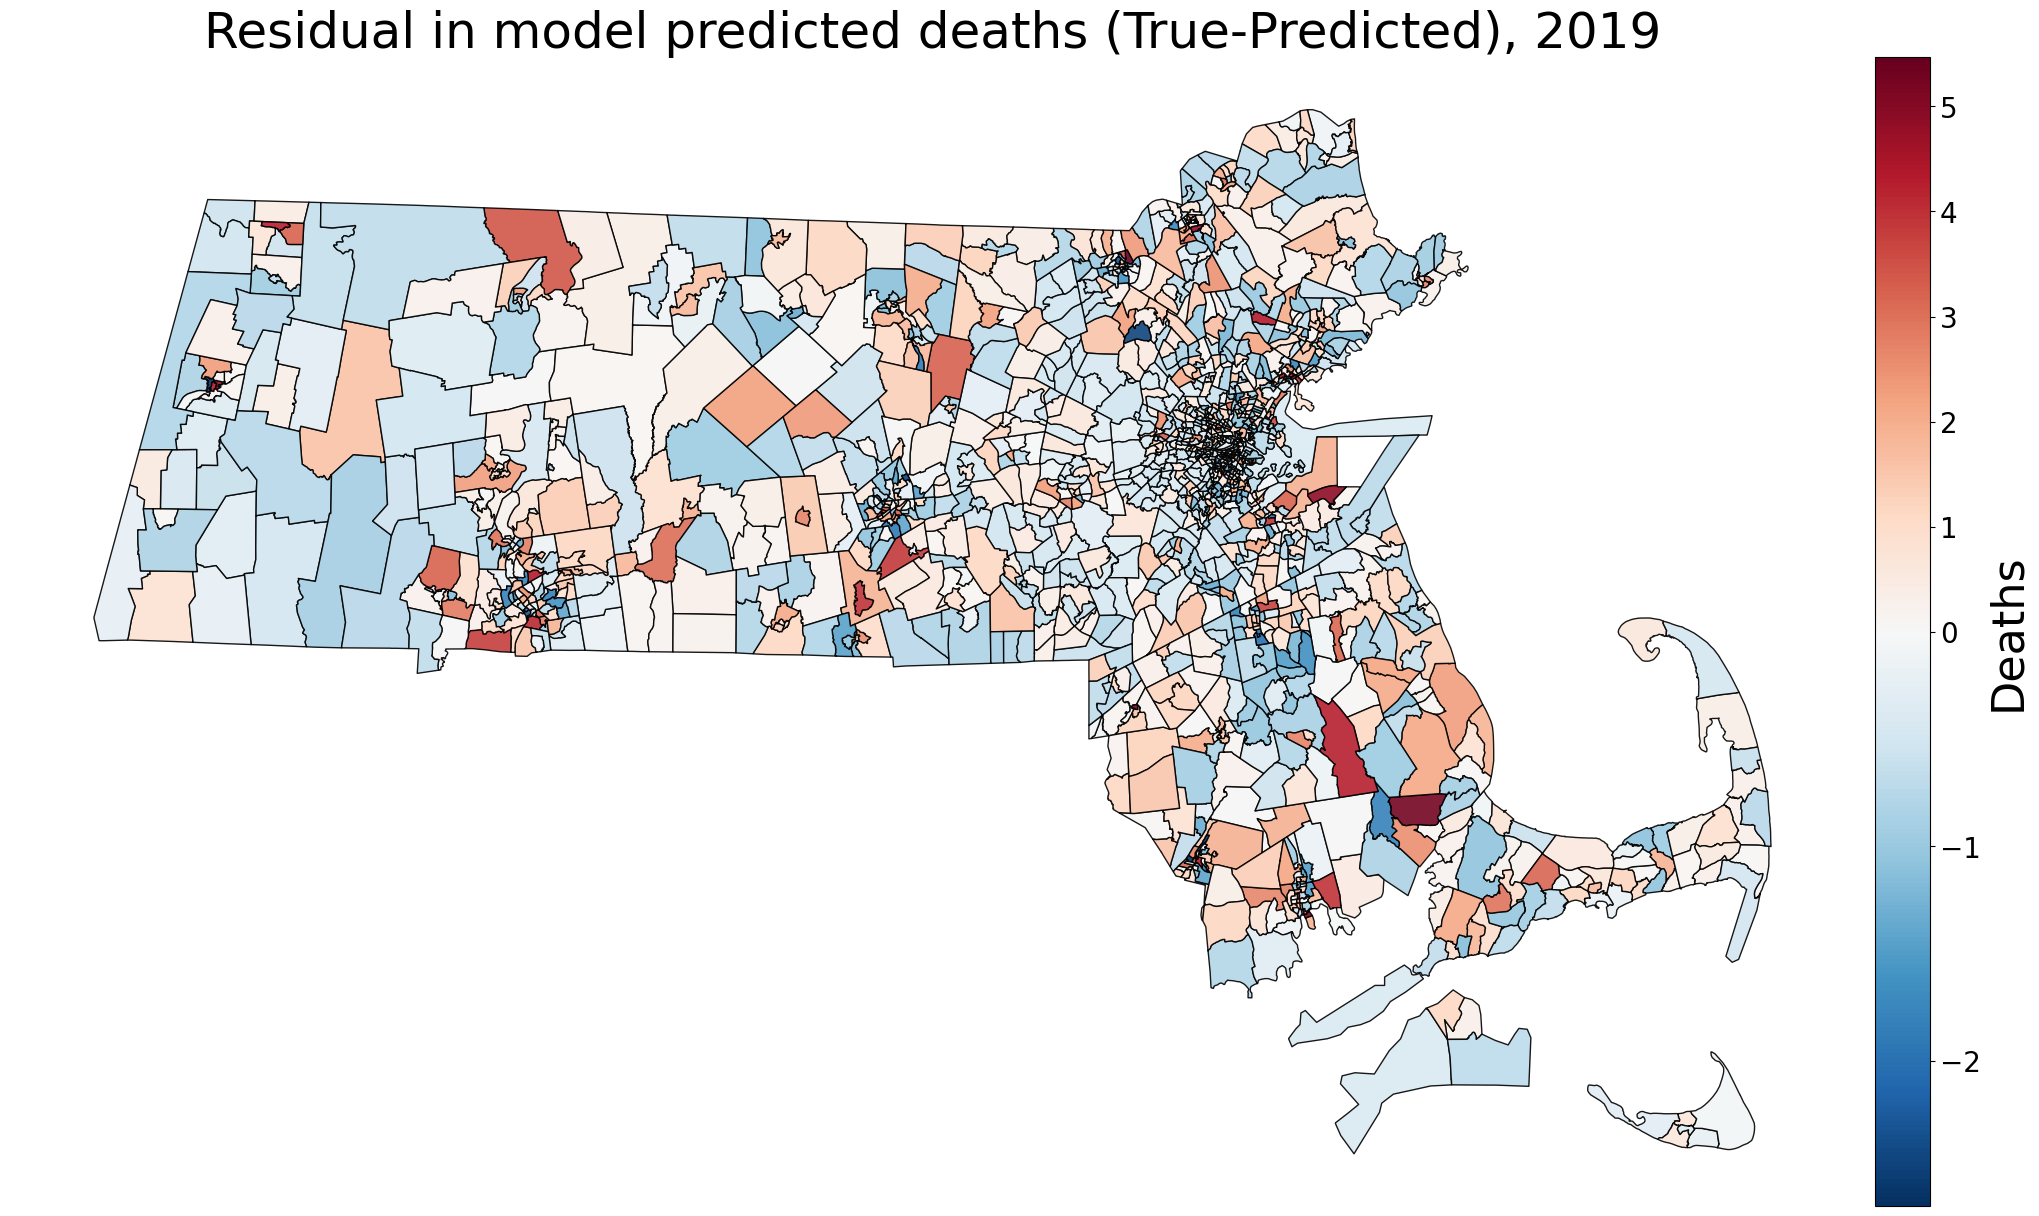

In [43]:
data='residuals'
cmap='RdBu_r'
zoom=11
dpi=100

#w,s,e,n = states.total_bounds

residual_gdf.crs = "EPSG:4326"

cropped_gdf = residual_gdf[(residual_gdf['lat']>42.2)&(residual_gdf['lat']<42.4)&
                           (residual_gdf['lon']>-71.2)&(residual_gdf['lon']<-70.93)]

f,ax = plt.subplots(1,1, figsize=(20,12), sharex=True, sharey=True, dpi=dpi)
f.tight_layout(pad=0.8)
ax.set_axis_off()
minx, miny, maxx, maxy = cropped_gdf.to_crs(epsg=3857).total_bounds
#ax.set_xlim(minx, maxx-(maxx-minx)*0.4)
#ax.set_ylim(miny, maxy)
plt.title('Residual in model predicted deaths (True-Predicted), 2019',fontsize=36)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ux = residual_gdf.to_crs(epsg=3857).plot(data, ax=ax, edgecolor='k', cmap=cmap,
                                         vmin=-3, vmax=5,norm=norm,
                                         alpha = 0.9, legend=True, cax=cax)
cax.tick_params(labelsize=20)
#ctx.add_basemap(ux, zoom=zoom,reset_extent=True,source=ctx.providers.Esri.WorldTerrain);

plt.ylabel('Deaths', fontsize=32)
# Use savefig to save your map
plt.savefig('NNResidual_2019.png',bbox_inches='tight')
plt.show()

In [40]:
import matplotlib
norm = matplotlib.colors.TwoSlopeNorm( vcenter=0)